<a href="https://colab.research.google.com/github/Santiago-Quinteros/Random_Forest_Segmentation_IRM/blob/main/Random_Forest_Segmentation_IRM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### TAF Health - UE Patient Numérique
## TP I.3 | Segmentation par apprentissage statistique en imagerie de perfusion

---

L'objectif de ce TP est de développer un modèle de **segmentation** de **tumeurs hépatiques** à partir d'images *dynamic contrast-enhanced MRI* (DCE-MRI), à l'aide de **forêts aléatoires**.

Au préalable, importons dans l'espace de stockage de la session Colab les images fournies.

Vous disposez de **7 examens** avec segmentations vérités-terrain associées.

## Partie 1 - Gestion et visualisation des données

La fonction `read_exam( )` fournie ci-dessous permets de lire pour un examen d'indice `exam_nb` :
- les images **préalablement recalées** acquises au temps sans injection (`WI`), artériel (`AR`), veineux précoce (`EV`) et veineux tardif (`LV`)
- un masque de segmentation (0 : en dehors du foie, 1 : foie sain, 2 : tumeur hépatique)

In [ ]:
import nibabel

def read_exam(exam_nb):
    image_WI = nibabel.load('mri-%02d-WI.nii.gz'%(exam_nb))
    image_AR = nibabel.load('mri-%02d-AR.nii.gz'%(exam_nb))
    image_EV = nibabel.load('mri-%02d-EV.nii.gz'%(exam_nb))
    image_LV = nibabel.load('mri-%02d-LV.nii.gz'%(exam_nb))
    mask = nibabel.load('mri-%02d-mask.nii.gz'%(exam_nb))
    return image_WI, image_AR, image_EV, image_LV, mask

Les examens de 1 à 6 serviront d'examens d'**apprentissage** tandis que l'examen 7 servira d'examen de **test**.

In [ ]:
train_ids, test_id = [1,2,3,4,5,6], 7

Visualisons les données de la base d'apprentissage.

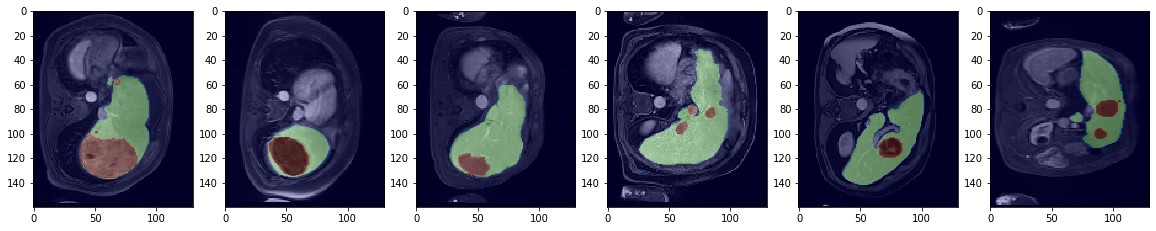

In [ ]:
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt

EV_slices, mask_slices = [], []
for train_id in train_ids:
    image_WI, image_AR, image_EV, image_LV, mask = read_exam(train_id)
    a = np.unique(np.where(mask.get_fdata()==2.)[2])
    z = a[int(2*len(a)/3)]
    EV_slices.append(resize(image_EV.get_fdata()[:,:,z],(160,130),mode='reflect'))
    mask_slices.append(resize(mask.get_fdata()[:,:,z],(160,130),mode='reflect'))

plt.figure(figsize=(20, 15))
for i in range(len(train_ids)):
    plt.subplot(1, len(train_ids), i+1)
    plt.imshow(EV_slices[i], cmap='gray', interpolation='nearest')
    plt.imshow(mask_slices[i], cmap='jet', alpha=0.3)
plt.show()

#### **Question 1** - Afficher les coupes axiales d'indice 27 des images `WI`, `AR`, `EV`, `LV` issues de l'examen de test ainsi que le masque de segmentation associé. Pour rappel, la routine `____.get_fdata()` renvoie le tableau de voxels associée à une image NIfTI.

In [ ]:
slice_ = 27
image_WI, image_AR, image_EV, image_LV, mask = read_exam(test_id)
slice_WI = image_WI.get_fdata()[:,:,slice_]
slice_AR = image_AR.get_fdata()[:,:,slice_]
slice_EV = image_EV.get_fdata()[:,:,slice_]
slice_LV = image_LV.get_fdata()[:,:,slice_]
slice_mask = mask.get_fdata()[:,:,slice_].astype(np.uint8)

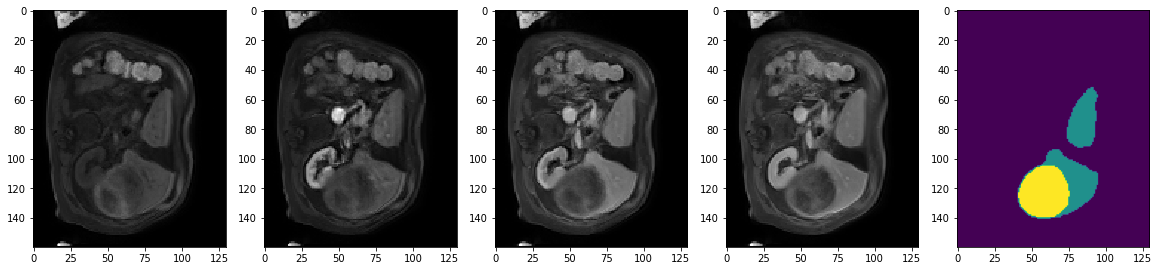

In [ ]:
plt.figure(figsize=(20, 15))
plt.subplot(1, 5, 1)
plt.imshow(slice_WI, cmap='gray', interpolation='nearest')
plt.subplot(1, 5, 2)
plt.imshow(slice_AR, cmap='gray', interpolation='nearest')
plt.subplot(1, 5, 3)
plt.imshow(slice_EV, cmap='gray', interpolation='nearest')
plt.subplot(1, 5, 4)
plt.imshow(slice_LV, cmap='gray', interpolation='nearest')
plt.subplot(1, 5, 5)
plt.imshow(slice_mask)
plt.show()

In [ ]:
print(np.unique(slice_mask))

[0 1 2]


#### **Question 2** - Pour l'examen de test, afficher comment évolue l'intensité moyenne des zones hépatiques **saines** et **tumorales** au cours du temps.

[98.36484490398819, 125.22895125553914, 153.35376661742984, 149.66617429837518]


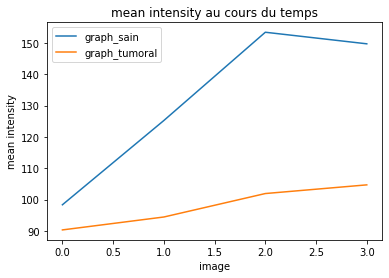

In [ ]:
#Partie sain mask=1
#parte malade mask=2
#je dois plotter la moyenne de chaque image sain et chaque image malade ensamble
graph_sain=[]
graph_tumoral=[]

for i in np.unique(slice_mask):
    if i==1:
        graph_sain.append(np.mean(slice_WI[slice_mask==(i)]))
        graph_sain.append(np.mean(slice_AR[slice_mask==(i)]))
        graph_sain.append(np.mean(slice_EV[slice_mask==(i)]))
        graph_sain.append(np.mean(slice_LV[slice_mask==(i)]))
    if i==2:
        graph_tumoral.append(np.mean(slice_WI[slice_mask==(i)]))
        graph_tumoral.append(np.mean(slice_AR[slice_mask==(i)]))
        graph_tumoral.append(np.mean(slice_EV[slice_mask==(i)]))
        graph_tumoral.append(np.mean(slice_LV[slice_mask==(i)]))

print(graph_sain)
plt.plot(graph_sain, label='graph_sain')
plt.plot(graph_tumoral, label='graph_tumoral')

plt.xlabel("image")
plt.ylabel("mean intensity")
plt.title("mean intensity au cours du temps")

# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()




#### **Question 3** - Sur quelle phase peut-on le mieux distinguer les deux types de tissus ?

**Réponse :** Sur l'image 2 (EV) car il y a le contrast le plus grand entre la partie sain et la partie tumoral

## Partie 2 - Apprentissage statistique par forêt aléatoire n'exploitant qu'une seule phase

#### **Question 4** - Ecrire une fonction `data, vec_mask = exam2vec_mono(image_EV, mask)` créant un vecteur contenant les intensités (`data`) de l'image acquise au temps veineux précoce (`EV`) **à l'intérieur du foie uniquement** ainsi que la vérité-terrain associée (`vec_mask`).

In [ ]:
def exam2vec_mono(image_EV, mask):
    vec_EV = image_EV.get_fdata()[mask.get_fdata()!= 0]
    vec_mask = mask.get_fdata()[mask.get_fdata()!= 0].reshape(-1, 1)
    data = vec_EV.reshape(-1, 1)
    return data, vec_mask



#### **Question 5** - Réaliser l'apprentissage d'une forêt aléatoire ([RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)) en exploitant les images au temps veineux précoce (EV) issues des examens 1 à 6. Fixer le nombre d'arbres à 15 (`n_estimator=15`). [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) sera utilisé pour la normalisation des données.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

for idx, train_id in enumerate(train_ids):
    image = read_exam(train_id)[2]
    mask = read_exam(train_id)[4]
    data, vec_mask = exam2vec_mono(image, mask)
    if idx > 0:
        train_data = np.concatenate((train_data, data),axis=0)
        train_mask = np.concatenate((train_mask, vec_mask),axis=0)
    else:
        train_data = data
        train_mask = vec_mask

print(train_data.shape)
print(train_mask.shape)
#los datos son las intensidades de la imagen EV que es la que habiamos dicho que era mejor para estudiar solo dentro del higado
#tengo un vector con todas las intensidades en cada una de las imagenes y cual deberia ser su mascara. Todo esto fue para usar todas las imagenes a la vez. Luego a la funcion random forests le paso esto y hace un forest que clasifica automaticamente las intensidades
#Claro lo que le estoy pasando es un chorro de pixeles que tienen asociada su intensidad con un numero (el de la mascara)
scaler = StandardScaler()
scaler.fit(train_data)
scaler.transform(train_data)

clf_mono = RandomForestClassifier(n_estimators=15, random_state=0)

clf_mono.fit(train_data, train_mask.ravel()) # A COMPLETER

(609435, 1)
(609435, 1)


RandomForestClassifier(n_estimators=15, random_state=0)

#### **Question 6** - Réaliser la prédiction du modèle entrainé sur l'examen de test. **Précision : on suppose le masque du foie connu.**

In [ ]:
image_EV = read_exam(test_id)[2] # A COMPLETER
flatten_ = image_EV.get_fdata().flatten()
test_image = flatten_.reshape(-1,1)
#Es como la funcion exam2vec_mono pero sin usar la mascara (no la tengo)
#lo que tengo es la imagen_EV de test y tengo que ver como la clasifica mi modelo (no tengo mascara)

#normalizo

scaler.transform(test_image)

#predigo
estimation_1 = clf_mono.predict(test_image) #devuelve la mascara segun el modelo entrenado



#reshape
seg_1 = np.reshape(estimation_1, image_EV.shape) #lo devuelve como matriz para hacer la imagen


#post processing
#SOLO QUIERO SABER QUE ES TUMOR O NO DENTRO DEL HIGADO, PARA ESO ESTA HECHO EL MODELO, NO PARA IDENTIFICAR EL HIGADO
mask=read_exam(test_id)[4]

seg_1[mask.get_fdata()==0]=0 #Siempre se aplican asi las mascaras




# A COMPLETER (normalisation, prédiction, reshape, post-processing étant donné le masque du foie connu)

#### **Question 7** - Visualiser le résultat de segmentation sur la coupe axiale 27, comparer (qualitativement) avec la vérité-terrain puis commenter.

In [ ]:
slice_ = 27
slice_seg_mono = seg_1[:,:,slice_] # A COMPLETER (résultat de segmentation sur la coupe axial 27)

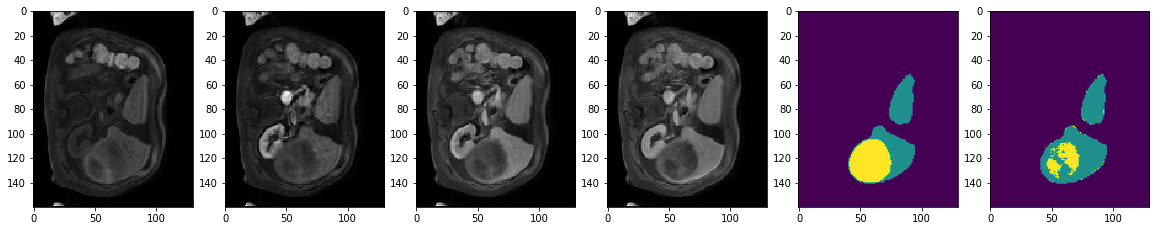

In [ ]:
plt.figure(figsize=(20, 15))
plt.subplot(1, 6, 1)
plt.imshow(slice_WI, cmap='gray', interpolation='nearest')
plt.subplot(1, 6, 2)
plt.imshow(slice_AR, cmap='gray', interpolation='nearest')
plt.subplot(1, 6, 3)
plt.imshow(slice_EV, cmap='gray', interpolation='nearest')
plt.subplot(1, 6, 4)
plt.imshow(slice_LV, cmap='gray', interpolation='nearest')
plt.subplot(1, 6, 5)
plt.imshow(slice_mask)
plt.subplot(1, 6, 6)
plt.imshow(slice_seg_mono)
plt.show()

**Commentaires :** On peut regarder qu'il manquent des features pour une bonne classification

Le code fourni ci-dessous permets de calculer le **score Dice**.

In [ ]:
def compute_dice(res, gt, domain, label):
    A = gt == label
    B = res == label
    C = domain != 0
    TP = len(np.nonzero(A*B*C)[0])
    FN = len(np.nonzero(A*(~B)*C)[0])
    FP = len(np.nonzero((~A)*B*C)[0])
    DICE = 0
    if (FP+2*TP+FN) != 0:
        DICE = float(2)*TP/(FP+2*TP+FN)
    return DICE*100

#### **Question 8** - Calculer le score Dice (en 3D) pour les tissus hépatiques sains et tumoraux de l'examen de test.

In [ ]:
# tissus hépatiques sains
healthy_dice_mono = compute_dice(seg_1, mask.get_fdata(),  mask.get_fdata(), 1)
print('dice (tissus sains) :', healthy_dice_mono)

# tissus hépatiques tumoraux
tumor_dice_mono = compute_dice(seg_1, mask.get_fdata(),  mask.get_fdata(), 2)
print('dice (tissus tumoraux) :', tumor_dice_mono)

dice (tissus sains) : 78.4423508901331
dice (tissus tumoraux) : 46.113555415880995


## Partie 3 - Apprentissage statistique multi-phase

#### **Question 9** - Ecrire une fonction `data, vec_mask = exam2vec_multi(image_WI, image_AR, image_EV, image_LV, mask)` créant des vecteurs contenant les intensités (`data`) des différentes images (`WI`, `AR`, `EV`, `LV`) **à l'intérieur du foie uniquement** ainsi que la vérité-terrain associée (`vec_mask`).

In [ ]:
def exam2vec_multi(image_WI, image_AR, image_EV, image_LV, mask):
    vec_WI,_ = exam2vec_mono(image_WI, mask)
    vec_AR,_ = exam2vec_mono(image_AR, mask)
    vec_EV,_ = exam2vec_mono(image_EV, mask)
    vec_LV,_ = exam2vec_mono(image_LV, mask)
    _,vec_mask = exam2vec_mono(image_EV, mask)
    data = np.column_stack((vec_WI,vec_AR,vec_EV,vec_LV))

    return data, vec_mask


#### **Question 10** - Réaliser l'apprentissage de la forêt aléatoire (mêmes paramètres que précédemment) en exploitant cette fois toutes les images (`WI`, `AR`, `EV`, `LV`) issues des examens 1 à 6.

In [ ]:
# A COMPLETER
#TENGO QUE DETERMINAR QUE ES MI TRAIN_DATA, QUE ES JUNTAR TODO LOS DATA DE LAS IMAGENES

for idx, train_id in enumerate(train_ids):
    image_WI, image_AR, image_EV, image_LV, mask = read_exam(train_id)

    data, vec_mask = exam2vec_multi(image_WI, image_AR, image_EV, image_LV, mask)

    if idx > 0:
        train_data = np.concatenate((train_data, data),axis=0)
        train_mask = np.concatenate((train_mask, vec_mask),axis=0)
    else:
        train_data = data
        train_mask = vec_mask
print(train_data.shape)
scaler = StandardScaler()
scaler.fit(train_data)
scaler.transform(train_data)
print(train_data.shape)
clf_multi = RandomForestClassifier(n_estimators=15, random_state=0)

clf_multi.fit(train_data, train_mask.ravel())  # A COMPLETER
#AHORA EN EL RANDOM FOREST VOS PASAS UNA IMAGEN CON TODOS LOS TIPOS Y TE LOS RELACIONA CON LA MASCARA QUE ES EL SEGUNDO ELEMENTO DE ESTA ULTIMA LINEA (ver fit en guia si hay dudas)


(609435, 4)
(609435, 4)


RandomForestClassifier(n_estimators=15, random_state=0)

#### **Question 11** - Réaliser la prédiction du modèle multi-phase sur l'examen de test. **Comme précédemment, on suppose le masque du foie connu.**

In [ ]:
# A COMPLETER
# ES COMO LA PARTE QUE YA HICIMOS PERO CON VARIAS IMAGENES

image_WI, image_AR, image_EV, image_LV, mask = read_exam(test_id)
vec_WI = image_WI.get_fdata().flatten().reshape(-1,1)
vec_AR = image_AR.get_fdata().flatten().reshape(-1,1)
vec_EV = image_EV.get_fdata().flatten().reshape(-1,1)
vec_LV = image_LV.get_fdata().flatten().reshape(-1,1)
test_image = np.column_stack((vec_WI,vec_AR,vec_EV,vec_LV))

#Es como la funcion exam2vec_mono pero sin usar la mascara (no la tengo)
#lo que tengo son las imagenes de test y tengo que ver como la clasifica mi modelo (no tengo mascara)

#normalizo

scaler.transform(test_image)

#predigo
estimation_1 = clf_multi.predict(test_image) #devuelve la mascara segun el modelo entrenado



#reshape
seg_1 = np.reshape(estimation_1, image_EV.shape) #lo devuelve como matriz para hacer la imagen


#post processing
#SOLO QUIERO SABER QUE ES TUMOR O NO DENTRO DEL HIGADO, PARA ESO ESTA HECHO EL MODELO, NO PARA IDENTIFICAR EL HIGADO

seg_1[mask.get_fdata()==0]=0 #Siempre se aplican asi las mascaras




# A COMPLETER (normalisation, prédiction, reshape, post-processing étant donné le masque du foie connu)

#### **Question 12** - Evaluer qualitativement et quantitativement (à l'aide du score Dice) l'apport du multi-phase comparé au cas mono-phase. Commenter.

In [ ]:
slice_ = 27
slice_seg_multi = seg_1[:,:,slice_] # A COMPLETER (résultat de segmentation sur la coupe axial 27)

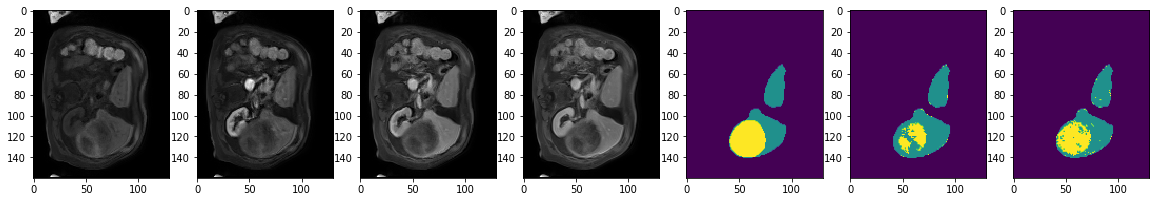

In [ ]:
plt.figure(figsize=(20, 15))
plt.subplot(1, 7, 1)
plt.imshow(slice_WI, cmap='gray', interpolation='nearest')
plt.subplot(1, 7, 2)
plt.imshow(slice_AR, cmap='gray', interpolation='nearest')
plt.subplot(1, 7, 3)
plt.imshow(slice_EV, cmap='gray', interpolation='nearest')
plt.subplot(1, 7, 4)
plt.imshow(slice_LV, cmap='gray', interpolation='nearest')
plt.subplot(1, 7, 5)
plt.imshow(slice_mask)
plt.subplot(1, 7, 6)
plt.imshow(slice_seg_mono)
plt.subplot(1, 7, 7)
plt.imshow(slice_seg_multi)
plt.show()

In [ ]:
healthy_dice_multi = compute_dice(seg_1, mask.get_fdata(),  mask.get_fdata(), 1)
print(healthy_dice_mono, healthy_dice_multi)

78.4423508901331 84.06656447630499


In [ ]:
tumor_dice_multi = compute_dice(seg_1, mask.get_fdata(),  mask.get_fdata(), 2)
print(tumor_dice_mono, tumor_dice_multi)

46.113555415880995 70.11757415090118


**Commentaires :** Il est posible observer qu'il y a une ameilloration significatif avec l'information de tous les images.

#### **Question 13** - A l'aide de https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html, visualiser l'importance de chaque feature et commenter.

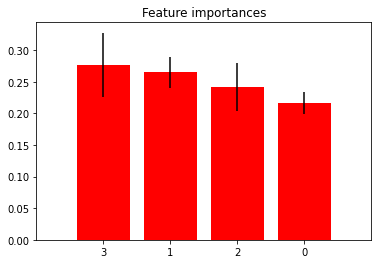

In [ ]:
importances = clf_multi.feature_importances_ # A COMPLETER
std = np.std([tree.feature_importances_ for tree in clf_multi.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature importances")
plt.bar(range(data.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(data.shape[1]), indices)
plt.xlim([-1, data.shape[1]])
plt.show()

In [ ]:
#Sigma 1 es si quiero que la region 1 sea un voxel o una region
#Sigma 2 es si quiero que la region 2 sea un voxel o una region
#si seteo la posicion en (0,0,0) puedo comparar una region con mi voxel

def add_neighbours_intensity_diff(image_data, sigma1=0, sigma2=0, posRegion1=(0,0,0), posRegion2=None, beta=1, mode='constant'):
    gaussian1 = gaussian_filter(input=image_data, sigma=sigma1)
    shift1 = gaussian1.shape * np.array(posRegion1) * -1
    region1 = shift(input=gaussian1, shift=shift1, mode=mode)
    diff = region1
    if posRegion2 != None:
        gaussian2 = gaussian_filter(input=image_data, sigma=sigma2)
        shift2 = gaussian2.shape * np.array(posRegion2) * -1
        region2 = shift(input=gaussian2, shift=shift2, mode=mode)
        diff -= region2 * beta
    return diff

        # Voxel immediate Neighbours difference with raw intensity
#    nb_z_pos_diff_1 = add_neighbours_intensity_diff(image.get_fdata(), sigma=1, posRegion2=(0,0,0.004)).flatten()
#    nb_z_pos_diff_2 = add_neighbours_intensity_diff(image.get_fdata(), sigma=2, posRegion2=(0,0,0.004)).flatten()
    nb_x_neg_diff_3 = add_neighbours_intensity_diff(image.get_fdata(), sigma1=3, posRegion2=(-0.004,0,0)).flatten()
    nb_x_pos_diff_3 = add_neighbours_intensity_diff(image.get_fdata(), sigma1=3, posRegion2=(0.004,0,0)).flatten()
    nb_y_neg_diff_3 = add_neighbours_intensity_diff(image.get_fdata(), sigma1=3, posRegion2=(0,-0.004,0)).flatten()
    nb_y_pos_diff_3 = add_neighbours_intensity_diff(image.get_fdata(), sigma1=3, posRegion2=(0,0.004,0)).flatten()
    nb_z_neg_diff_3 = add_neighbours_intensity_diff(image.get_fdata(), sigma1=3, posRegion2=(0,0,-0.004)).flatten()
    nb_z_pos_diff_3 = add_neighbours_intensity_diff(image.get_fdata(), sigma1=3, posRegion2=(0,0,0.004)).flatten()

**Commentaires :** L'image avec l'apport le plus grand est l'image LV et le moins significatif est le WI

## Partie 4 - Ajout d'un pré-traitement

#### **Question 14** - Créer une fonction `filter_exam_bregman(image_WI,image_AR,image_EV,image_LV,weight=0.1)` permettant de filtrer les images multi-phases d'un examen à l'aide d'un filtre régularisant la variation totale (*Total Variation*, TV) avec un poids de `0.1`. Visualiser l'effet du filtrage sur l'examen de test. Plus d'info par ici : https://scikit-image.org/docs/dev/api/skimage.restoration.html#skimage.restoration.denoise_tv_bregman

In [ ]:
from skimage.restoration import denoise_tv_bregman

def filter_exam_bregman(image_WI,image_AR,image_EV,image_LV,weight=0.1):
    image_WI.get_fdata()[:,:,:] = denoise_tv_bregman(image_WI.get_fdata()) # A COMPLETER
    image_AR.get_fdata()[:,:,:] = denoise_tv_bregman(image_AR.get_fdata())
    image_EV.get_fdata()[:,:,:] = denoise_tv_bregman(image_EV.get_fdata())
    image_LV.get_fdata()[:,:,:] = denoise_tv_bregman(image_LV.get_fdata())

In [ ]:
image_WI, image_AR, image_EV, image_LV, mask = read_exam(test_id)
filter_exam_bregman(image_WI, image_AR, image_EV, image_LV) # A COMPLETER
slice_EV_filter = image_EV.get_fdata()[:,:,slice_]
fig, axes = plt.subplots(1, 2, figsize=(8, 8))
ax = axes.ravel()
ax[0].set_title("original")
ax[0].imshow(slice_EV, cmap='gray') # A COMPLETER
ax[1].set_title("filtered")
ax[1].imshow(slice_EV_filter, cmap='gray') # A COMPLETER
plt.show()

TypeError: ignored

#### **Question 15** - Réaliser l'apprentissage et la prédiction en exploitant des données multi-phases filtrées.

In [ ]:
# A COMPLETER (apprentissage)
# A COMPLETER
#TENGO QUE DETERMINAR QUE ES MI TRAIN_DATA, QUE ES JUNTAR TODO LOS DATA DE LAS IMAGENES
for idx, train_id in enumerate(train_ids):
    image_WI, image_AR, image_EV, image_LV, mask = read_exam(train_id)
    filter_exam_bregman(image_WI, image_AR, image_EV, image_LV)

    data, vec_mask = exam2vec_multi(image_WI, image_AR, image_EV, image_LV, mask)

    if idx > 0:
        train_data = np.concatenate((train_data, data),axis=0)
        train_mask = np.concatenate((train_mask, vec_mask),axis=0)
    else:
        train_data = data
        train_mask = vec_mask

scaler = StandardScaler()
scaler.fit(train_data)
scaler.transform(train_data)

clf_multi_filt = RandomForestClassifier(n_estimators=15, random_state=0)

clf_multi_filt.fit(train_data, train_mask.ravel())  # A COMPLETER



TypeError: ignored

In [ ]:
# A COMPLETER
# ES COMO LA PARTE QUE YA HICIMOS PERO CON VARIAS IMAGENES

image_WI, image_AR, image_EV, image_LV, mask = read_exam(test_id)
filter_exam_bregman(image_WI, image_AR, image_EV, image_LV)
vec_WI = image_WI.get_fdata().flatten().reshape(-1,1)
vec_AR = image_AR.get_fdata().flatten().reshape(-1,1)
vec_EV = image_EV.get_fdata().flatten().reshape(-1,1)
vec_LV = image_LV.get_fdata().flatten().reshape(-1,1)

test_image_multi= np.column_stack((vec_WI,vec_AR,vec_EV,vec_LV))

#Es como la funcion exam2vec_mono pero sin usar la mascara (no la tengo)
#lo que tengo son las imagenes de test y tengo que ver como la clasifica mi modelo (no tengo mascara)

#normalizo

scaler.transform(test_image_multi)

#predigo
estimation_1 = clf_multi_filt.predict(test_image) #devuelve la mascara segun el modelo entrenado



#reshape
seg_1 = np.reshape(estimation_1, image_EV.shape) #lo devuelve como matriz para hacer la imagen


#post processing
#SOLO QUIERO SABER QUE ES TUMOR O NO DENTRO DEL HIGADO, PARA ESO ESTA HECHO EL MODELO, NO PARA IDENTIFICAR EL HIGADO

seg_1[mask.get_fdata()==0]=0 #Siempre se aplican asi las mascaras




# A COMPLETER (normalisation, prédiction, reshape, post-processing étant donné le masque du foie connu)

#### **Question 16** - Evaluer qualitativement et quantitativement (à l'aide du score Dice) l'ajout du pré-traitement. Commenter.

In [ ]:
slice_seg_filter = seg_1[:,:,slice_] # A COMPLETER (résultat de segmentation sur la coupe axial 27)

In [ ]:
plt.figure(figsize=(20, 15))
plt.subplot(1, 8, 1)
plt.imshow(slice_WI, cmap='gray', interpolation='nearest')
plt.subplot(1, 8, 2)
plt.imshow(slice_AR, cmap='gray', interpolation='nearest')
plt.subplot(1, 8, 3)
plt.imshow(slice_EV, cmap='gray', interpolation='nearest')
plt.subplot(1, 8, 4)
plt.imshow(slice_LV, cmap='gray', interpolation='nearest')
plt.subplot(1, 8, 5)
plt.imshow(slice_mask)
plt.subplot(1, 8, 6)
plt.imshow(slice_seg_mono)
plt.subplot(1, 8, 7)
plt.imshow(slice_seg_multi)
plt.subplot(1, 8, 8)
plt.imshow(slice_seg_filter)
plt.show()

In [ ]:
healthy_dice_filter =  compute_dice(seg_1, mask.get_fdata(),  mask.get_fdata(), 1)
print(healthy_dice_mono, healthy_dice_multi, healthy_dice_filter)

In [ ]:
tumor_dice_filter = compute_dice(seg_1, mask.get_fdata(),  mask.get_fdata(), 2)
print(tumor_dice_mono, tumor_dice_multi, tumor_dice_filter)

**Commentaires** : Il y a une ameilloration en utilisant le filtre, mais c'est pas tres signifiant.



---

